# Model Classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [349]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=300
data_dir="Datasets/Train"

In [284]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets/Train",
    
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2342 files belonging to 32 classes.


In [285]:
class_names = dataset.class_names
class_names

['Citroen DS 6WR',
 'Citroën  C-Elysée',
 'Citroën DS4',
 'GMC truck 2014',
 'Golf 7',
 'ISUZU DMAX 4P',
 'Land Rover Charleroi R. Leone',
 'MITSUBISHI ASX',
 'Mazda 3 hatchback',
 'Mazda 6',
 'Mini Cooper SD 5-door (2015)',
 'Renault Captur',
 'Renault Duster 2011',
 'Renault Duster 2014',
 'Renault symbol',
 'Toyota Land Cruiser 79 4.2 l Diesel 4x4',
 'Toyota RAV 4 2013',
 'Toyota yaris',
 'amarok',
 'clio 4',
 'fiesta ford',
 'jeep liberty 2014',
 'jeep wrangler 2014',
 'mazda cx 9 2013',
 'mini cooper s cabrio r57',
 'passat',
 'peugeot 2008',
 'peugeot 207',
 'peugeot 301',
 'polo 7',
 'toyota corolla 2014',
 'volw ibeetel']

In [286]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[13 11 18  9 26  6 28  0 16  0 18 28 15 24 15 25  2 25 23 11 11  9 28  8
  8 15  0  3 20  5  6 17]


### Visualize some of the images from our dataset

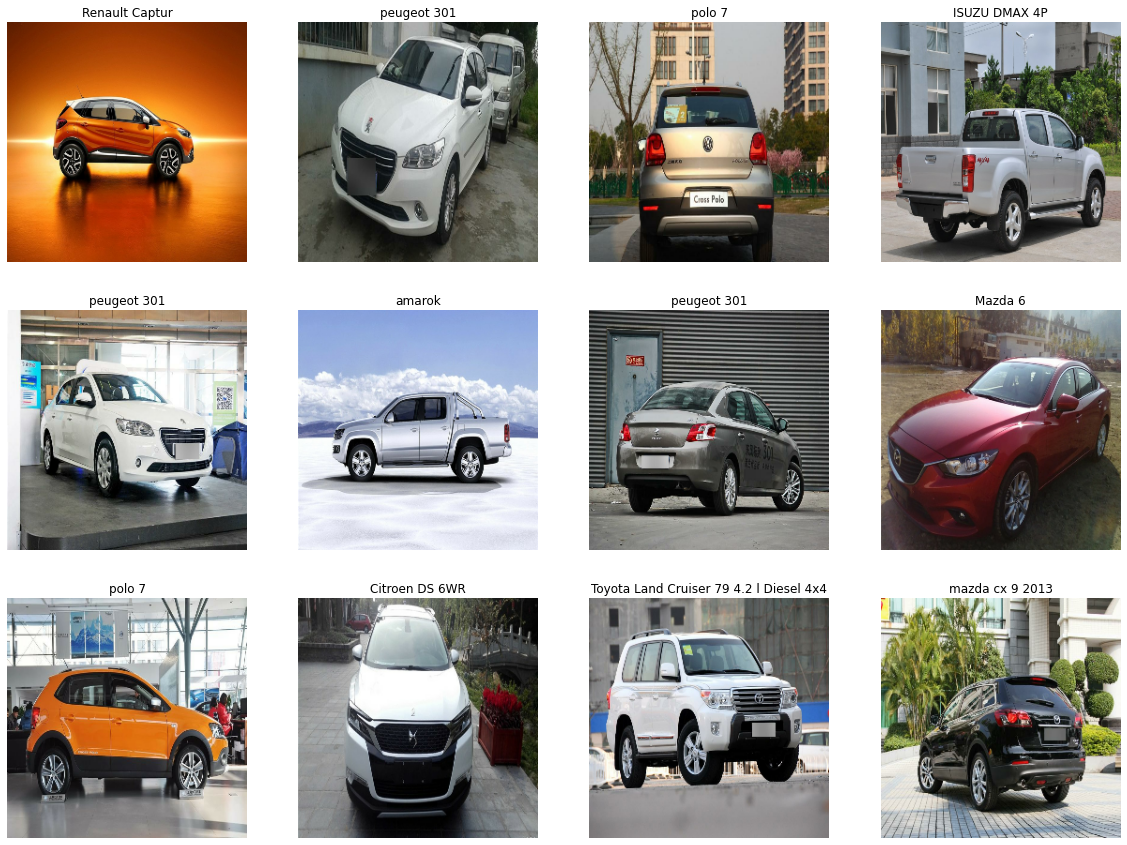

In [287]:
plt.figure(figsize=(20, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [293]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [294]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [295]:
len(train_ds)

51

In [296]:
len(val_ds)

14

In [297]:
len(test_ds)

9

In [298]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [299]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation


In [494]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


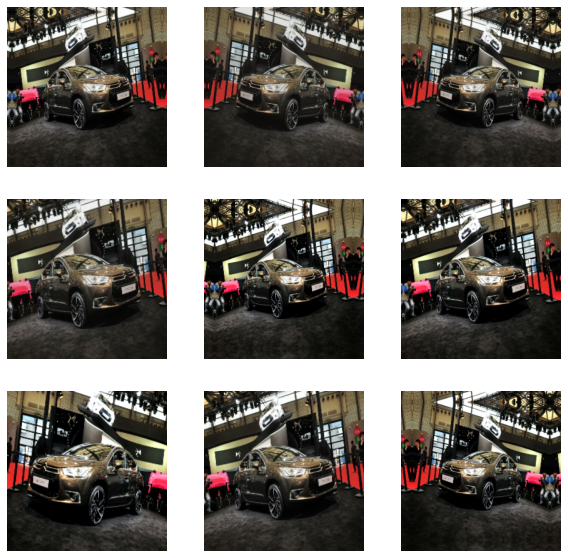

In [495]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [310]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 32

model = models.Sequential([
    data_augmentation,
    resize_and_rescale,
    
    
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
      
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
      
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [311]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_42 (Sequential)   (None, 256, 256, None)    0         
_________________________________________________________________
sequential_41 (Sequential)   (None, 256, 256, None)    0         
_________________________________________________________________
conv2d_47 (Conv2D)           (32, 254, 254, 64)        1792      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (32, 127, 127, 64)        0         
_________________________________________________________________
dropout_103 (Dropout)        (32, 127, 127, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (32, 125, 125, 64)        36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (32, 62, 62, 64)        

### Compiling the Model


In [312]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [314]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
51/51 [==============================] - 190s 4s/step - loss: 3.2041 - accuracy: 0.1009 - val_loss: 3.2585 - val_accuracy: 0.0893
Epoch 2/5
51/51 [==============================] - 195s 4s/step - loss: 3.1911 - accuracy: 0.0785 - val_loss: 3.1406 - val_accuracy: 0.1183
Epoch 3/5
51/51 [==============================] - 194s 4s/step - loss: 3.1352 - accuracy: 0.1139 - val_loss: 3.1552 - val_accuracy: 0.1339
Epoch 4/5
51/51 [==============================] - 192s 4s/step - loss: 3.0992 - accuracy: 0.1096 - val_loss: 3.1100 - val_accuracy: 0.1473
Epoch 5/5
51/51 [==============================] - 195s 4s/step - loss: 3.1003 - accuracy: 0.1077 - val_loss: 3.0988 - val_accuracy: 0.1518


In [54]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 524ms/step - loss: 0.3753 - accuracy: 0.8594


### Plotting the Accuracy and Loss Curves

In [410]:
history

In [411]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 41}

In [412]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [413]:
type(history.history['loss'])

list

In [414]:
len(history.history['loss'])

100

In [415]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1259757280349731,
 1.094635009765625,
 1.0917243957519531,
 1.0576907396316528,
 1.1153823137283325]

In [416]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

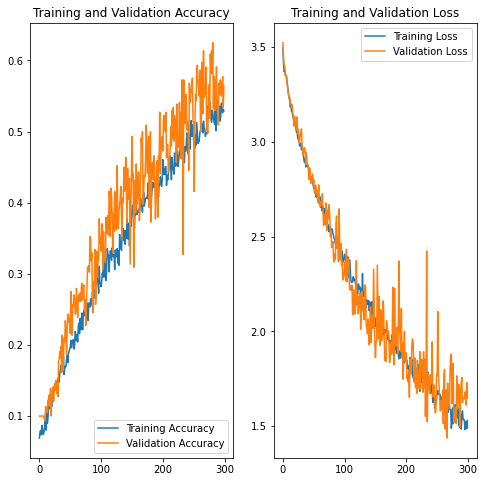

In [395]:
EPOCHS=300
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

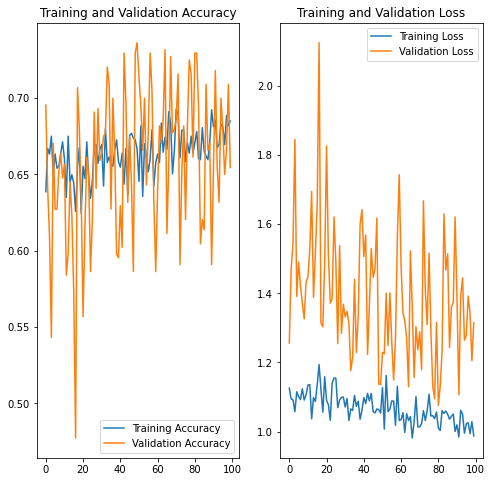

In [417]:
EPOCHS=100
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Mazda 6
predicted label: peugeot 301


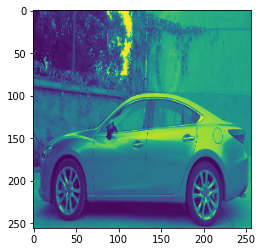

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

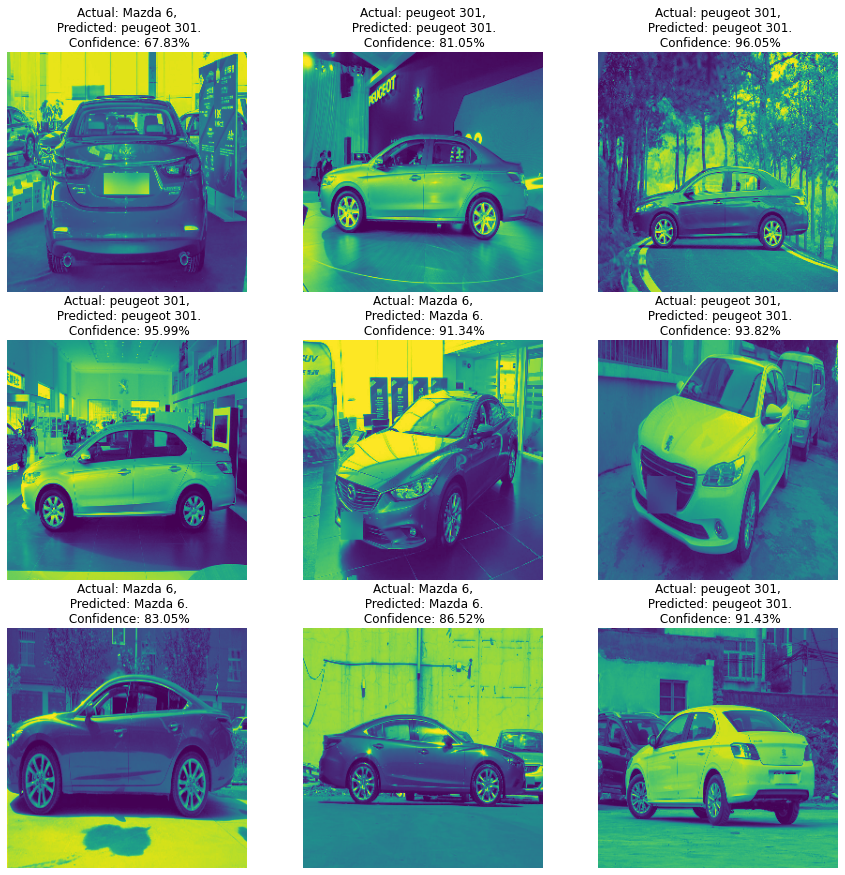

In [59]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [62]:
predicted_class1=[]
actual_class1=[]
for images, labels in test_ds.take(1):
    for i in range(9):   
        predicted_class2, confidence = predict(model, images[i].numpy())
        predicted_class1.append(predicted_class2)
        actual_class2 = class_names[labels[i]] 
        actual_class1.append(actual_class2)

In [63]:
from sklearn.metrics import classification_report 
print(classification_report(actual_class1,predicted_class1))

              precision    recall  f1-score   support

     Mazda 6       0.75      0.75      0.75         4
 peugeot 301       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



##  Using Transfer Learning

In [421]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.layers import BatchNormalization, Dropout
from keras.models import Model

In [496]:
img_height,img_width=256,256
batch_size=32
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2342 files belonging to 32 classes.
Using 1874 files for training.


In [497]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2342 files belonging to 32 classes.
Using 468 files for validation.


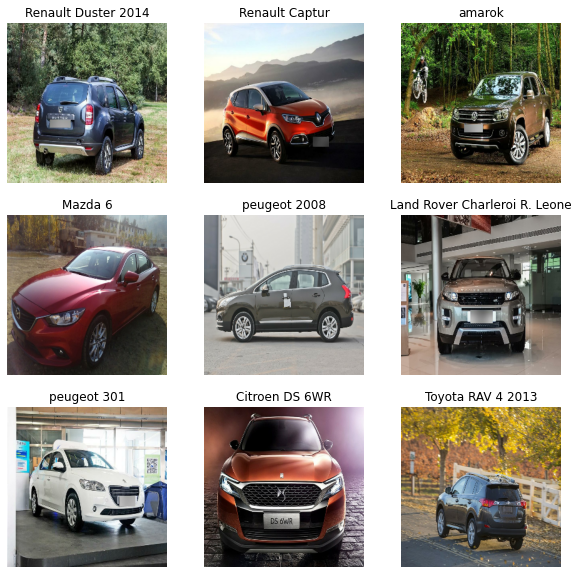

In [498]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [499]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [500]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 3


In [501]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=32,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


In [480]:
'''inputs =tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)

x = pretrained_model(inputs, training=False)

outputs = tf.keras.layers.Dense(32)(x)
model = tf.keras.Model(inputs, outputs)'''

In [502]:
resnet_model.add(pretrained_model)

In [503]:
# Let's take a look at the base model architecture
resnet_model.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [504]:

resnet_model.add(layers.Flatten())

resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(0.3))

resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(0.3))

resnet_model.add(layers.Dense(32, activation='softmax'))


In [505]:
resnet_model.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_65 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_172 (Dense)            (None, 256)               524544    
_________________________________________________________________
dropout_146 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_147 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 32)              

In [506]:
resnet_model.compile(optimizer=Adam(learning_rate=0.0003),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_dataset, validation_data=validation_dataset, epochs=20)

Epoch 1/20
59/59 [==============================] - 204s 3s/step - loss: 3.2936 - accuracy: 0.1025 - val_loss: 2.8724 - val_accuracy: 0.2366
Epoch 2/20
59/59 [==============================] - 196s 3s/step - loss: 2.7468 - accuracy: 0.2273 - val_loss: 2.4383 - val_accuracy: 0.3925
Epoch 3/20
59/59 [==============================] - 195s 3s/step - loss: 2.3378 - accuracy: 0.3372 - val_loss: 1.9954 - val_accuracy: 0.4570
Epoch 4/20
59/59 [==============================] - 195s 3s/step - loss: 1.9232 - accuracy: 0.4557 - val_loss: 1.6517 - val_accuracy: 0.5968
Epoch 5/20
59/59 [==============================] - 207s 4s/step - loss: 1.6190 - accuracy: 0.5390 - val_loss: 1.3497 - val_accuracy: 0.6505
Epoch 6/20
59/59 [==============================] - 198s 3s/step - loss: 1.3626 - accuracy: 0.5993 - val_loss: 1.2642 - val_accuracy: 0.6532
Epoch 7/20
59/59 [==============================] - 183s 3s/step - loss: 1.2127 - accuracy: 0.6409 - val_loss: 1.0786 - val_accuracy: 0.7016
Epoch 8/20
59

In [507]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

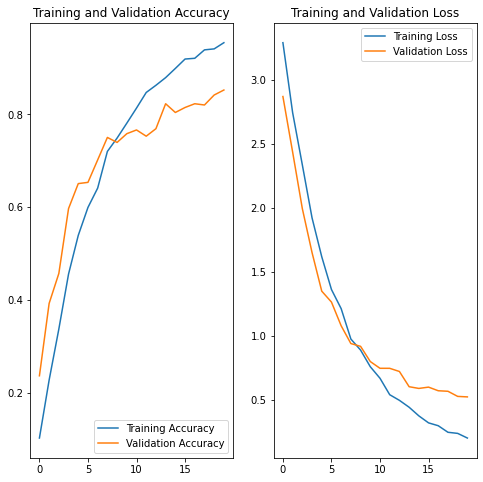

In [508]:
EPOCHS=20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [510]:
loss, accuracy = resnet_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 8s 3s/step - loss: 0.5177 - accuracy: 0.8438
Test accuracy : 0.84375


In [512]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = resnet_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

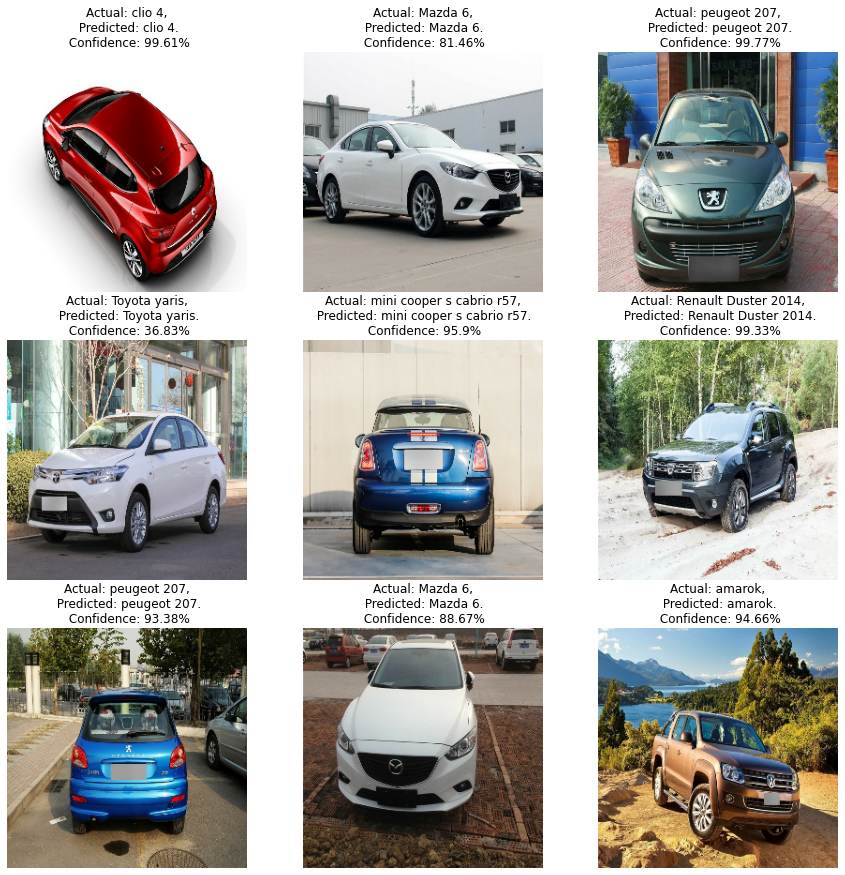

In [515]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
